In [110]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [111]:
# Load the data
votes = pd.read_csv("../data/fulldata.csv")

votes["round"] = votes["round"].astype("category")

votes = votes[votes["distance"] > 0]
votes = votes[votes["round"] == "final"]


votes = votes[votes["from_country"] != votes["to_country"]] #exclude self-votes
votes = votes[votes["to_country"] != "au"] #exclude Australia
votes = votes[votes["from_country"] != "au"] #exclude Australia
#print(len(votes[votes["from_country"] =="ma"]))
length_before = len(votes)
print("Rows before dropping NA Collums:", length_before)
votes.columns
votes = votes.dropna(subset=["from_country", "to_country", "distance", "total_points"])
length_after = len(votes)

print("Dropped", length_before - length_after, "rows due to missing values")
length_before = length_after
print("Rows before dropping NA after forcing numeric:", length_before)

Rows before dropping NA Collums: 34097
Dropped 0 rows due to missing values
Rows before dropping NA after forcing numeric: 34097


/tmp/ipykernel_57161/1129254551.py:2: DtypeWarning: Columns (20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  votes = pd.read_csv("../data/fulldata.csv")


In [112]:

votes.replace("..",float("nan"),inplace=True)
print(votes['GDP per capita (current US$)_to'])

votes["GDP per capita (current US$)_from"] = pd.to_numeric(votes["GDP per capita (current US$)_from"], errors='coerce')
votes["GDP per capita (current US$)_to"] = pd.to_numeric(votes["GDP per capita (current US$)_to"], errors='coerce')
votes = votes.dropna(subset=["GDP per capita (current US$)_from", "GDP per capita (current US$)_to"])
length_after = len(votes)
print("Dropped", length_before - length_after, "rows due to missing values")
print("Rows after dropping NA:", length_after)

0        1302.53149729892
1         1397.5948032844
2                     NaN
3         1451.2850779894
4        1162.12266831735
               ...       
49323        32610.110923
49324         8575.171134
49325        27331.209495
49326        12281.505849
49328        54343.226508
Name: GDP per capita (current US$)_to, Length: 34097, dtype: object
Dropped 361 rows due to missing values
Rows after dropping NA: 33736


In [113]:
votes["GDP_Difference"] = votes["GDP per capita (current US$)_from"] - votes["GDP per capita (current US$)_to"]


In [114]:
votes.head

<bound method NDFrame.head of        Unnamed: 0  year  round from_country to_country  total_points  \
0               0  1960  final           at         fr             1   
1               1  1960  final           at         gb             3   
3               3  1960  final           at         no             1   
4               4  1960  final           at         de             2   
5               5  1960  final           at         be             1   
...           ...   ...    ...          ...        ...           ...   
49323       49323  2023  final           gb         si             1   
49324       49324  2023  final           gb         al             0   
49325       49325  2023  final           gb         pt             0   
49326       49326  2023  final           gb         rs             0   
49328       49328  2023  final           gb         de             0   

       tele_points  jury_points  Year_from iso-alpha-3_from  ...  \
0              NaN          NaN      

In [115]:
votes["distance"] = votes["distance"].astype("int")
votes["distance"] = (votes["distance"] - votes["distance"].mean()) / votes[
    "distance"
].std()
votes["GDP_Difference"] = (votes["GDP_Difference"] - votes["GDP_Difference"].mean()) / votes[
    "GDP_Difference"
].std()


In [116]:
mixed_model = smf.mixedlm(
    formula="total_points ~ distance + GDP_Difference + year",
    re_formula='~distance', 
    data=votes,
    groups=votes["from_country"],
).fit()
print(mixed_model.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    total_points
No. Observations:    33736      Method:                REML        
No. Groups:          48         Scale:                 16.5610     
Min. group size:     18         Log-Likelihood:        -95333.7691 
Max. group size:     1244       Converged:             Yes         
Mean group size:     702.8                                         
-------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept            -72.596    3.270 -22.199 0.000 -79.006 -66.187
distance              -0.719    0.092  -7.820 0.000  -0.900  -0.539
GDP_Difference        -0.131    0.031  -4.251 0.000  -0.191  -0.070
year                   0.038    0.002  23.101 0.000   0.034   0.041
Group Var              0.246    0.016                          

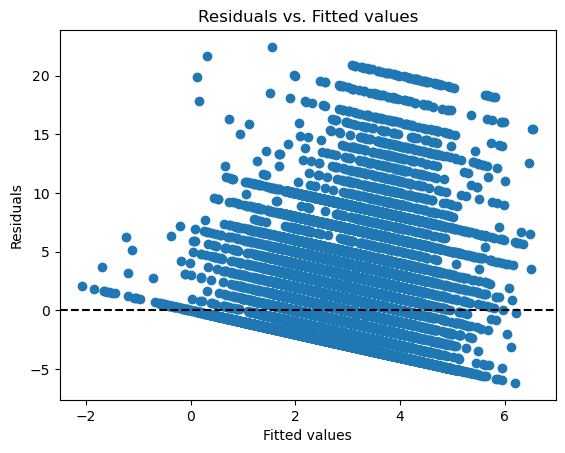

In [117]:
votes["residuals"] = mixed_model.resid
votes["fitted_values"] = mixed_model.fittedvalues

# Plot the residuals
plt.scatter(votes["fitted_values"], votes["residuals"])
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted values")
plt.axhline(y=0, color="black", linestyle="--")
plt.show()

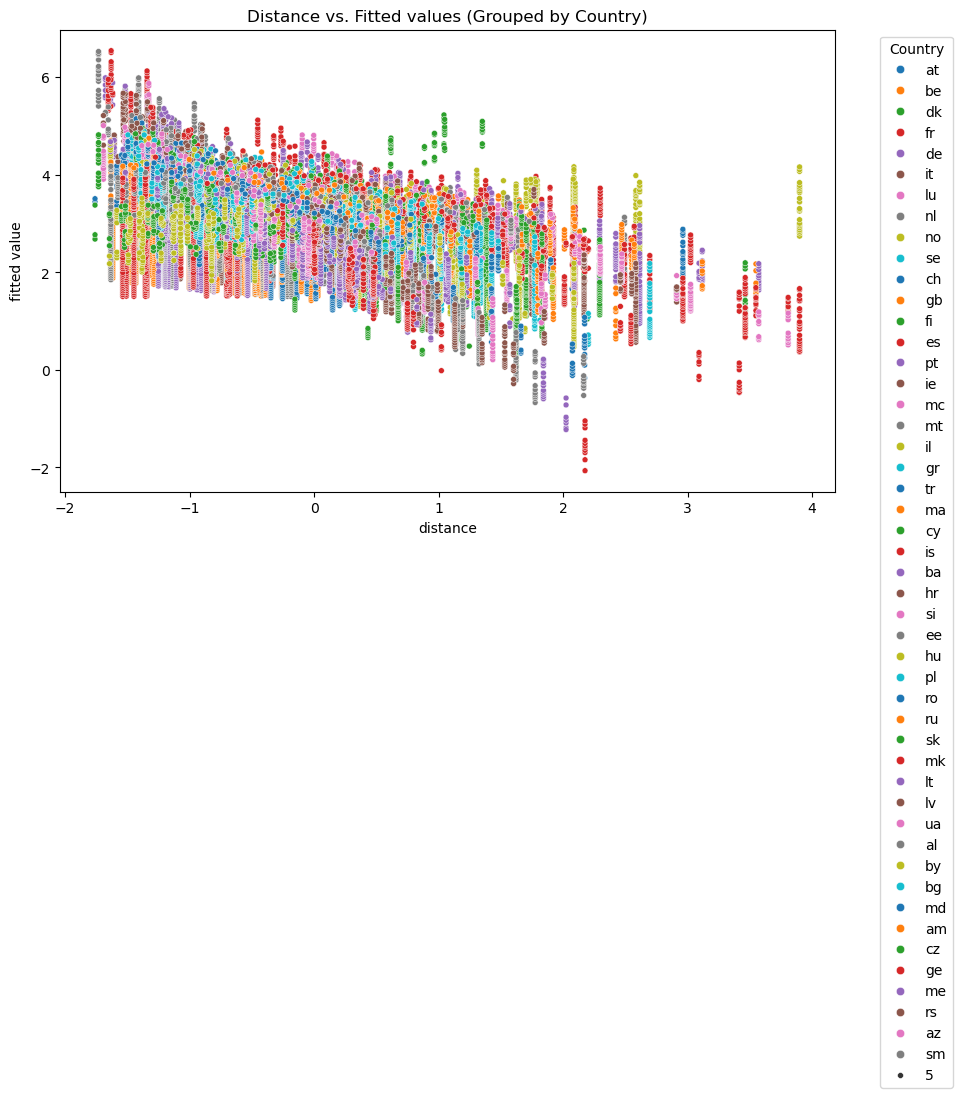

In [118]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'votes' has a column 'country' for grouping
sizes = [5 for _ in range(len(votes))]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=votes, 
    x="distance", 
    y="fitted_values", 
    hue="from_country",  # Group by country
    size=sizes, 
    palette="tab10"  # Use a predefined palette
)
plt.xlabel("distance")
plt.ylabel("fitted value")
plt.title("Distance vs. Fitted values (Grouped by Country)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



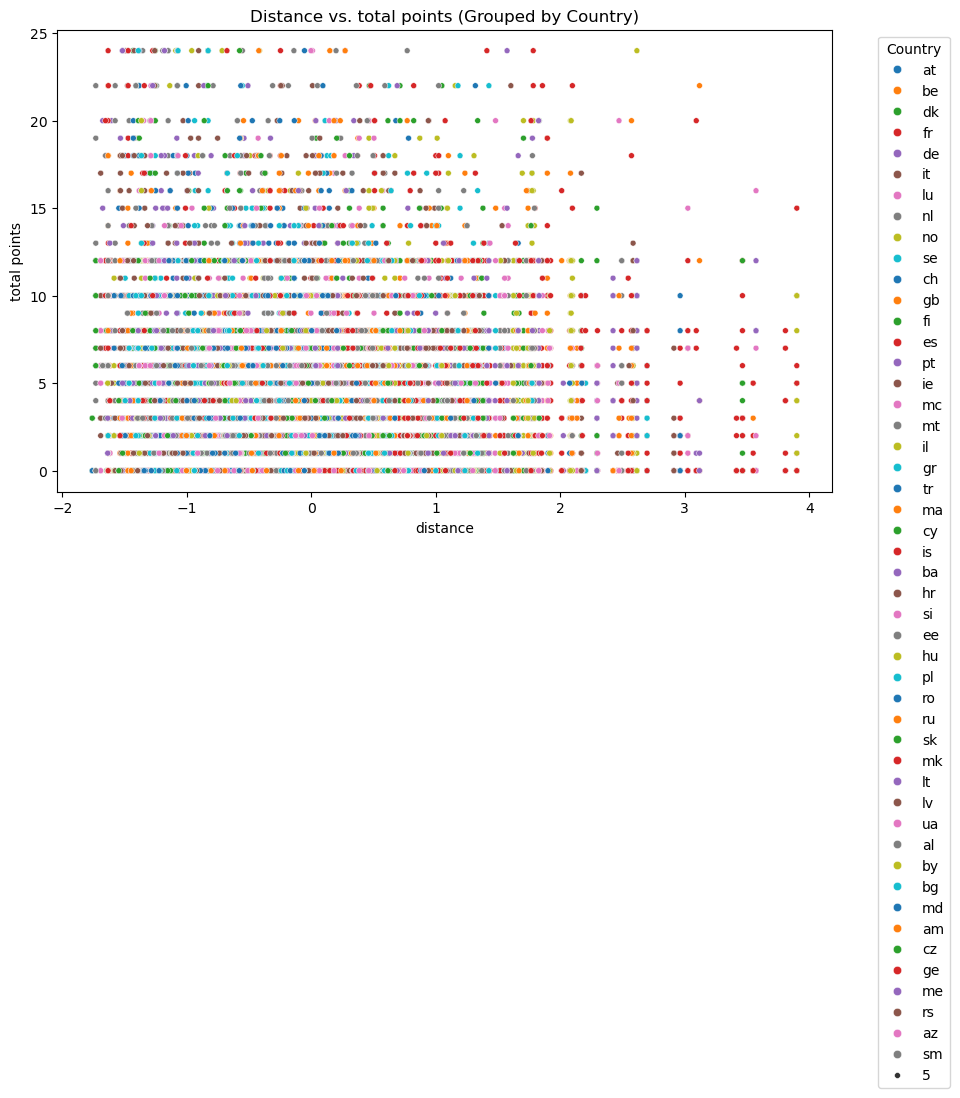

In [119]:
# Assuming 'votes' has a column 'country' for grouping
sizes = [5 for _ in range(len(votes))]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=votes, 
    x="distance", 
    y="total_points", 
    hue="from_country",  # Group by country
    size=sizes, 
    palette="tab10"  # Use a predefined palette
)
plt.xlabel("distance")
plt.ylabel("total points")
plt.title("Distance vs. total points (Grouped by Country)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

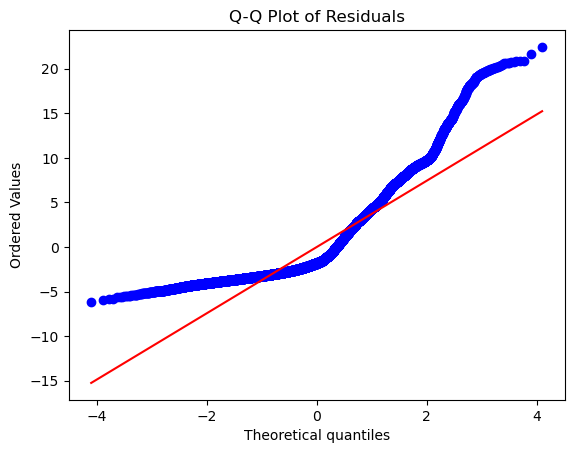

In [120]:
import scipy.stats as stats
# Assuming residuals are stored in votes["residuals"]
stats.probplot(votes["residuals"], dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()
